<a href="https://colab.research.google.com/github/zahraDehghanian97/Adversarially-Learned-Anomaly-Detection/blob/master/AE/AE_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


ImportError: ignored

# **arythmia**

In [85]:
data = scipy.io.loadmat("/content/drive/MyDrive/Colab Notebooks/Adversarially-Learned-Anomaly-Detection/data/arrhythmia.mat")
full_x_data = data["X"]
full_y_data = data['y']
x_train, x_test, y_train, y_test = train_test_split(full_x_data,full_y_data,test_size=0.2,random_state=42)

y_train = y_train.flatten().astype(int)
y_test = y_test.flatten().astype(int)
print("Scaling dataset")
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Scaling dataset


vanila AE

274
Epoch 1/20
3/3 [==============================] - 1s 69ms/step - loss: 0.1573 - val_loss: 0.1618
Epoch 2/20
3/3 [==============================] - 0s 16ms/step - loss: 0.1522 - val_loss: 0.1537
Epoch 3/20
3/3 [==============================] - 0s 17ms/step - loss: 0.1426 - val_loss: 0.1413
Epoch 4/20
3/3 [==============================] - 0s 15ms/step - loss: 0.1290 - val_loss: 0.1253
Epoch 5/20
3/3 [==============================] - 0s 23ms/step - loss: 0.1121 - val_loss: 0.1070
Epoch 6/20
3/3 [==============================] - 0s 26ms/step - loss: 0.0933 - val_loss: 0.0877
Epoch 7/20
3/3 [==============================] - 0s 18ms/step - loss: 0.0740 - val_loss: 0.0695
Epoch 8/20
3/3 [==============================] - 0s 20ms/step - loss: 0.0565 - val_loss: 0.0544
Epoch 9/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0425 - val_loss: 0.0432
Epoch 10/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0323 - val_loss: 0.0358
Epoch 11/20
3/3 [========

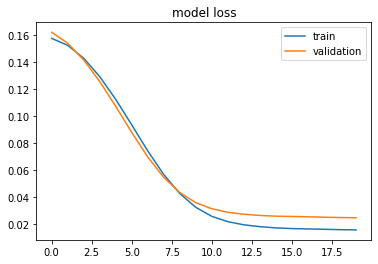

In [86]:
print(x_train.shape[1])
input_size = x_train.shape[1]
input_size = 274
hidden_size = 64
code_size = 8
epochs = 20
batch_size = 128

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size,name = "code_layer",activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)
# initialize
autoencoder = Model(inputs=x, outputs=r)
intermediate_layer_model = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer('code_layer').output)
autoencoder.compile(optimizer='adam', loss='mse')
# plot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))
# train
history = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, x_test))
# test
decoded_imgs = autoencoder.predict(x_test)
intermediate_output = intermediate_layer_model.predict(x_test)
print(intermediate_output.shape)
# loss
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


plot histogram z = 8


(452, 274)


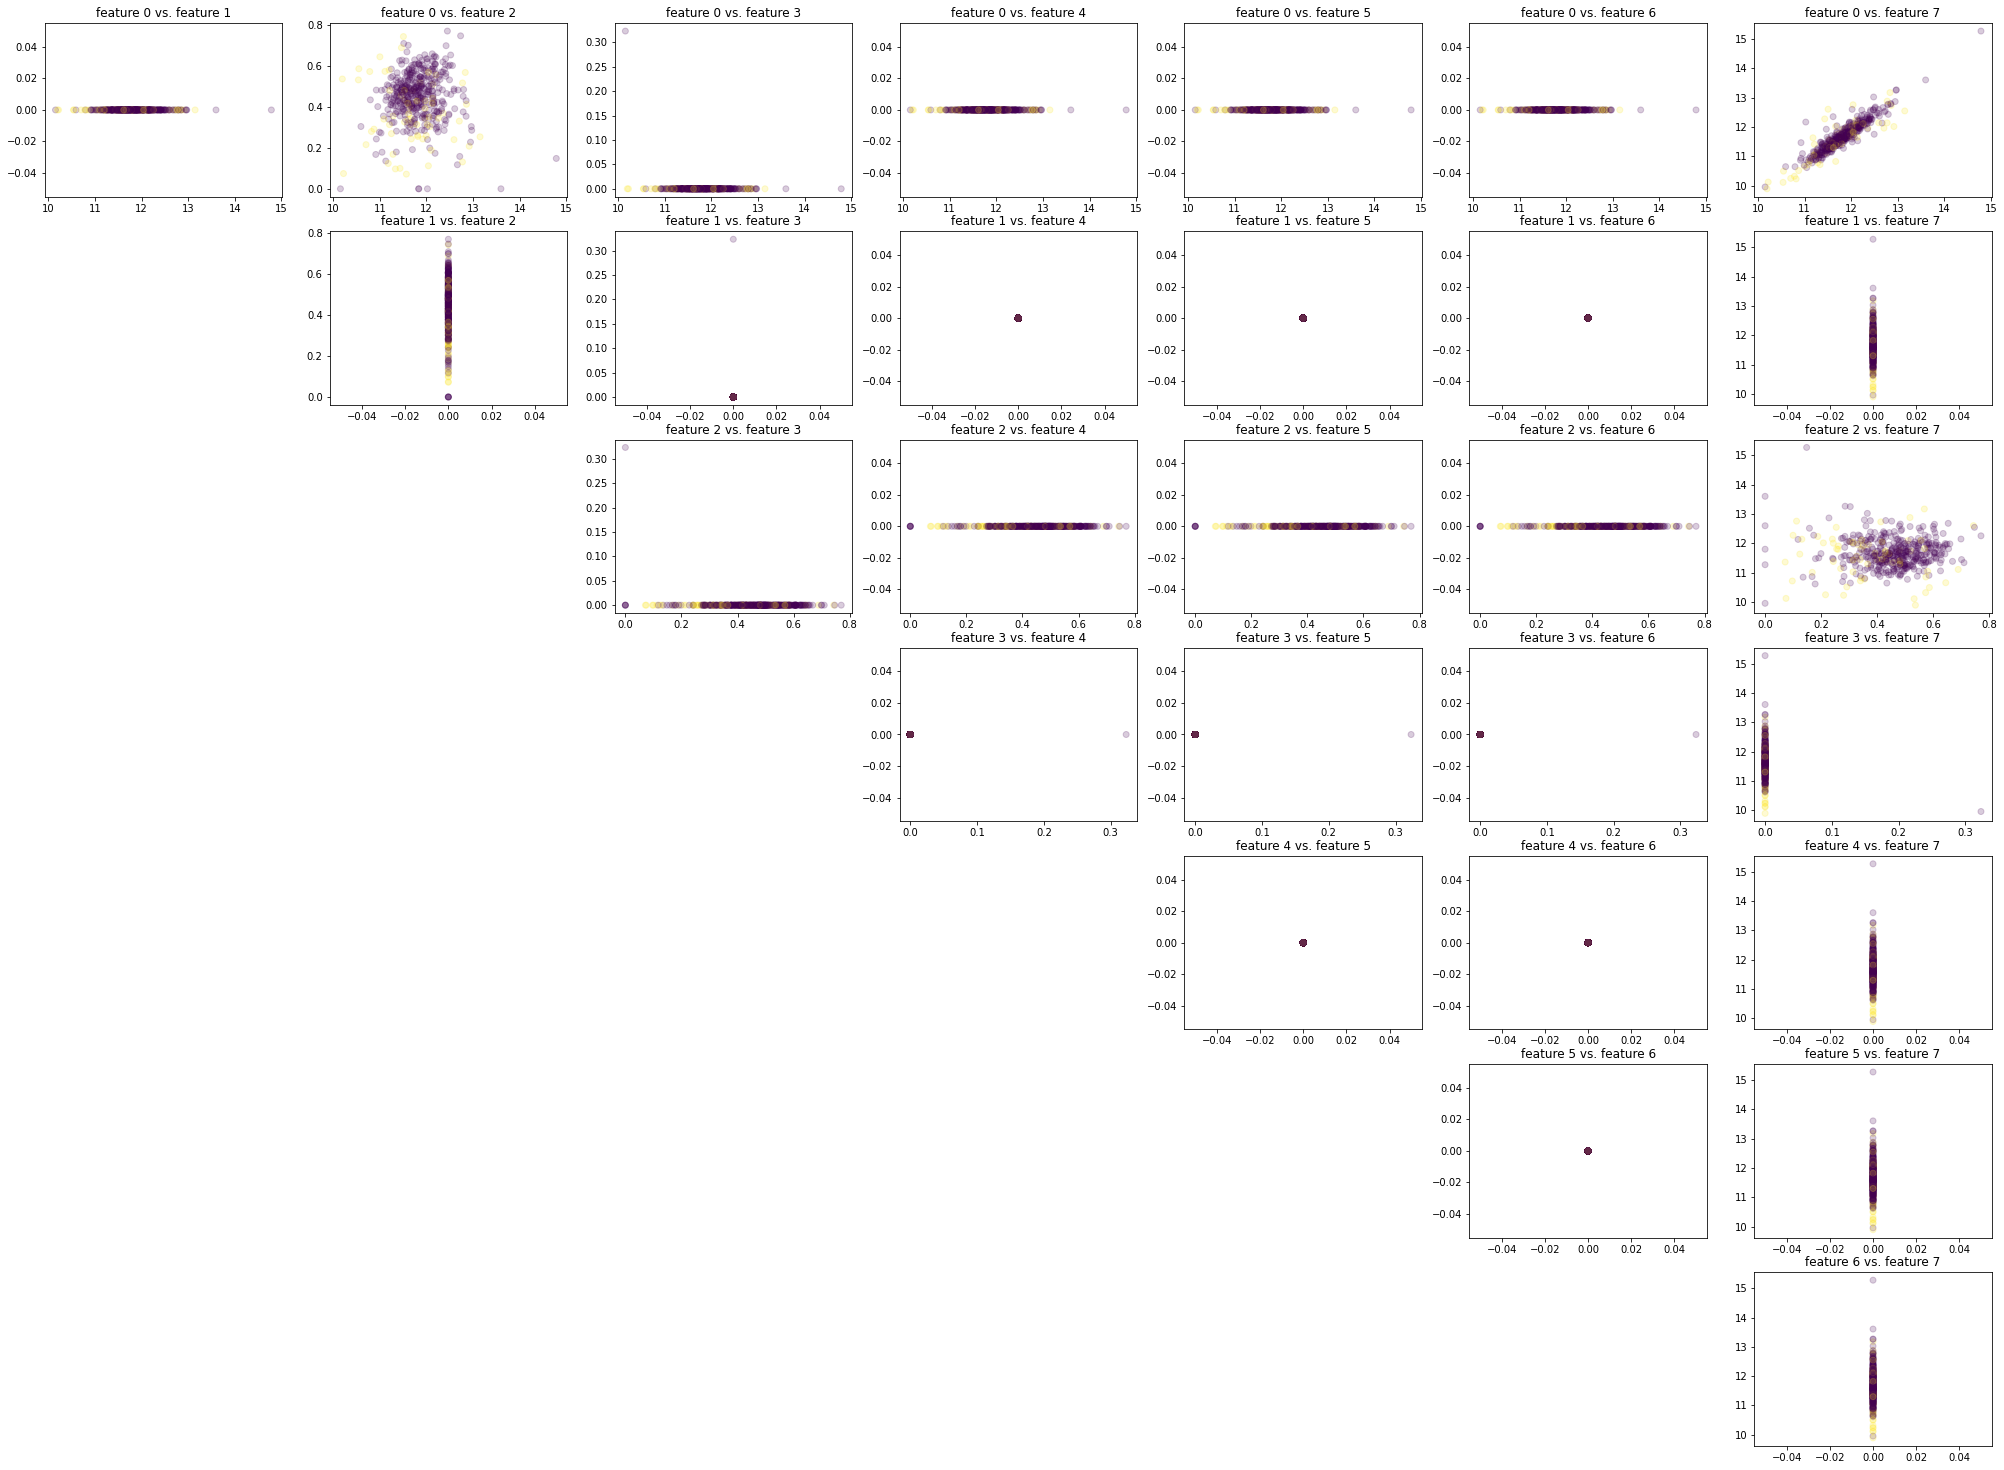

In [87]:
import matplotlib.gridspec as gridspec
alldata = np.concatenate((x_train,x_test), axis=0)
alllabel = np.concatenate((y_train,y_test))
print(alldata.shape)
code = intermediate_layer_model.predict(alldata)
fig = plt.figure(figsize=(40,30)) 
gs = gridspec.GridSpec(8, 8)
for i in range(code_size) :
  for j in range(i+1,code_size) :
    ax = plt.subplot(gs[i,j])
    ax.set_title("feature "+str(i)+" vs. feature "+str(j))
    ax.scatter(code[:, i], code[:, j], c=alllabel,alpha=0.2)
    fig.add_subplot(ax)
plt.show()


Variational AE

In [88]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
z_mean = Dense(code_size)(h)
z_log_var = Dense(code_size)(h)

In [89]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], code_size), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [90]:
z = Lambda(sampling, output_shape=(code_size,))([z_mean, z_log_var])

decoder_h = Dense(code_size, activation='relu')
decoder_mean = Dense(input_size, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

NameError: ignored

In [ ]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [ ]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss = vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 256)          200960      input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2)            514         dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            514         dense_9[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

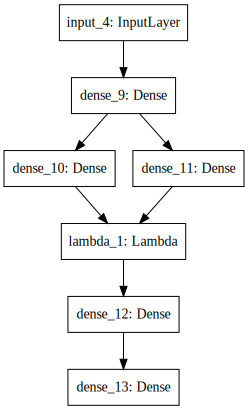

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

In [ ]:
history = vae.fit(x_train, x_train,shuffle=True, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 149us/step - loss: 193.8719 - val_loss: 173.6628
Epoch 2/50
60000/60000 [==============================] - 9s 144us/step - loss: 171.1773 - val_loss: 168.7714
Epoch 3/50
60000/60000 [==============================] - 9s 142us/step - loss: 167.4393 - val_loss: 166.2178
Epoch 4/50
60000/60000 [==============================] - 9s 144us/step - loss: 165.3063 - val_loss: 164.7818
Epoch 5/50
60000/60000 [==============================] - 9s 143us/step - loss: 163.8230 - val_loss: 163.8972
Epoch 6/50
60000/60000 [==============================] - 8s 141us/step - loss: 162.6410 - val_loss: 162.2503
Epoch 7/50
60000/60000 [==============================] - 9s 142us/step - loss: 161.5983 - val_loss: 161.2797
Epoch 8/50
60000/60000 [==============================] - 8s 141us/step - loss: 160.6299 - val_loss: 160.5893
Epoch 9/50
60000/60000 [==============================] - 9s 142us/ste

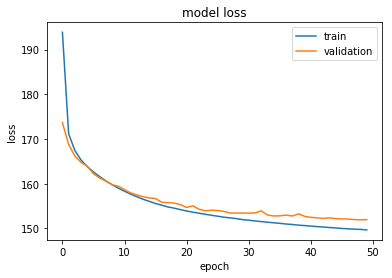

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()